In [9]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
font = {'family' : 'sans-serif',
        'weight' : 'normal',
        'size'   : 15}

font_large = {'family' : 'sans-serif',
        'weight' : 'normal',
        'size'   : 25}

plt.rc('font', **font)
plt.rcParams['axes.linewidth']=2.5
plt.rcParams['ytick.major.width'] = 2.5
#plt.rcParams['xtick.top'] = False
plt.rcParams['axes.spines.top'] = False
plt.rcParams['axes.spines.right'] = False
plt.rcParams['errorbar.capsize']=0
plt.rcParams['lines.linewidth']=3


In [12]:
run = '42_93_20190714'
agg_d = pd.read_csv('../../../../../RO/3PG Coupled Assay/EPPS_Assays/agg_variant_data_'+run+'.csv')
agg_d = agg_d[agg_d['mean norm rate [s-1]']>0.5]
uclust = pd.read_csv('../output/00_100p_tree/uclust_all_1.csv')
uclust['ID'] = uclust['Target'].apply(lambda x: x.split(' ')[0])
uclust['QID'] = uclust['Query'].apply(lambda x: x.split(' ')[0])

In [13]:
uclust_variants = uclust[uclust.ID.isin(agg_d.Variant)]
uclust_variants.set_index('ID',inplace=True)
with_species =uclust_variants[uclust_variants.Query.str.contains("\[")].Query.apply(lambda x: x.split("[")[1])
with_species[~with_species.str.contains('EC:')] = with_species[~with_species.str.contains('EC:')].apply(lambda x: x.split(']')[0])
with_species[with_species.str.contains('EC:')] = with_species[with_species.str.contains('EC:')].apply(lambda x: x.split('species=')[1]).apply(lambda x: x.split(' genus=')[0])
unique_species = with_species.reset_index().drop_duplicates()

true_unique_species = unique_species[unique_species.Query.str.contains(' ')]
true_unique_species.drop_duplicates(subset='ID',inplace=True)

/usr/lib/python3/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [14]:
unique_uclust_variants = pd.DataFrame(uclust_variants.reset_index()['ID'].drop_duplicates())
unique_uclust_agg_m = agg_d.merge(unique_uclust_variants,left_on='Variant',right_on='ID',how='left')
missing = unique_uclust_agg_m[unique_uclust_agg_m.ID.isna()].Variant
uclust_missing_variants =uclust[uclust.QID.isin(missing)]
uclust_missing_variants['V'] = uclust_missing_variants.QID
uclust_missing_variants_m = uclust.merge(uclust_missing_variants,left_on='Target',right_on='Target',suffixes=['','_y'])
uclust_missing_variants_m.set_index('V',inplace=True)
missing_species_labels = uclust_missing_variants_m[uclust_missing_variants_m.Query.str.contains('\[')].Query.apply(lambda x: x.split("[")[1]).apply(lambda x: x.split(']')[0])
missing_species = missing_species_labels[~missing_species_labels.str.contains('sp.')].reset_index().groupby('V').first().reset_index()
missing_species.columns = ['ID','Query']
all_species = pd.concat([true_unique_species,missing_species])
agg_d = agg_d.merge(all_species,left_on = 'Variant', right_on='ID',how='left')

/usr/lib/python3/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


In [15]:

agg_d.loc[agg_d.Query.str.len() > 32,'Query'] = agg_d[agg_d.Query.str.len() > 32].Query.apply(lambda x: ' '.join(x.split(' ')[:2]))
uclust_qid = uclust.set_index('QID')
w = uclust_qid.loc[agg_d[agg_d.Query.isna()].Variant]
w.dropna(inplace=True)
agg_d.loc[agg_d.Variant.isin(w[w.Query.str.contains('TARA')].ID),'Query'] = 'Tara metagenome'
agg_d.loc[agg_d.Variant.isin(w[~w.Query.str.contains('TARA')].ID),'Query'] = 'Unknown organism'
agg_d.loc[agg_d.Variant == 'Rr','Query'] = 'Rhodospirillum rubrum'
agg_d.loc[agg_d.Variant == 'AfM','Query'] = 'Acidithiobacillus ferrooxidans'
agg_d.loc[agg_d.Variant == 'RBC_20','Query'] = agg_d[agg_d.Variant == 'Rr'].Query.values
agg_d.loc[agg_d.Variant == 'Rr[D117V]','Query'] = agg_d[agg_d.Variant == 'Rr'].Query.values + 'Rr[D117V] mutant'
agg_d.loc[agg_d.Variant == 'AfM_O','Query'] = agg_d[agg_d.Variant == 'AfM'].Query.values
agg_d.loc[agg_d.Variant=='Rr','norm rate [s-1] sem'] = agg_d.loc[agg_d.Variant=='Rr','kcat sem']
agg_d.loc[agg_d.Variant == 'RBCSeed_24','Query'] = 'Gammaproteobacterial endosymbiont'
#f[f.Query.str.contains("\[")].Query.values
#fig = plt.figure(figsize=(5,20))


/usr/lib/python3/dist-packages/ipykernel_launcher.py:4: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  after removing the cwd from sys.path.


In [16]:
from Bio import SeqIO
#[x.description for x in SeqIO.parse('../data/milo_synthetized_rubisco.faa',format='fasta')]
uclust_70 = pd.read_csv('../output/01_70p_tree/uclust_all_0.7.csv')
types = pd.read_csv('../output/01_70p_tree/rubisco_types_70p.csv')
uclust_70['TID'] = uclust_70.Target.apply(lambda x: x.split(' ')[0])
uclust_70['QID'] = uclust_70.Query.apply(lambda x: x.split(' ')[0])
uclust_type = uclust_70.merge(types, left_on='TID',right_on='ID')
agg_d_with_type = agg_d.merge(uclust_type[['QID','type']],left_on='Variant',right_on='QID',how='left')

agg_d_with_type.loc[agg_d_with_type.Variant=='Rr','type'] = 'II'
agg_d_with_type.loc[agg_d_with_type.Variant=='RBC_67','type'] = 'II'
agg_d_with_type.loc[agg_d_with_type.Variant=='AfM','type'] = 'II'
agg_d_with_type.loc[agg_d_with_type.Variant=='RBC2_39','type'] = 'II'
#t = agg_d.merge(uclust[['QID','Target','ID']],left_on='Variant',right_on='QID')
#agg_d_with_type[agg_d_with_type.Variant==t[t.Variant.isin(agg_d_with_type.loc[agg_d_with_type.type.isna(),'Variant'])].ID_y.values[0]]
#t[t.Variant.isin(agg_d_with_type.loc[agg_d_with_type.type.isna(),'Variant'])].ID_y.values[0]
#uclust_type[uclust_type.QID.isin(t[t.Variant.isin(agg_d_with_type.loc[agg_d_with_type.type.isna(),'Variant'])].ID_y.values)]
#agg_d_with_type.loc[agg_d_with_type.type.isna()]
#agg_d_with_type[agg_d_with_type.type.isna()]
#agg_d_with_type[agg_d_with_type.type.isna()]
agg_d = agg_d_with_type[agg_d_with_type.type.isin(['II','II/III'])]

In [17]:
plant_data = pd.read_csv('DatasetS2_RubiscoKinetics_Merged.csv')
plants = ['C3 plants','C4 plants','Carnivorous plants','CAM plants','Fern','Gymnosperm','Bryophyte','Basal angiosperm','C3-C4 plants','C4-like plants']
plant_vC = plant_data[plant_data.taxonomy.isin(plants)].vC.dropna()
plant_25per_30_deg =pd.np.percentile(plant_vC,25)*(2.2**0.5)
plant_75per_30_deg =pd.np.percentile(plant_vC,75)*(2.2**0.5)

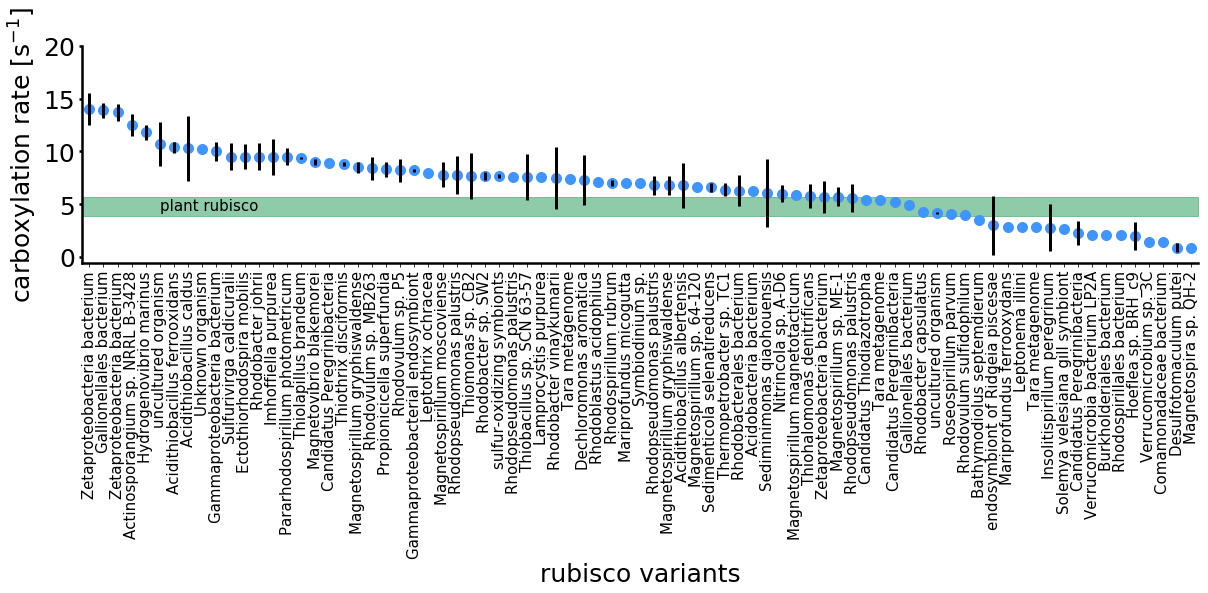

In [22]:
agg_d.loc[~agg_d['mean norm rate [s-1]'].isna(),'index'] = pd.np.arange(len(agg_d[~agg_d['mean norm rate [s-1]'].isna()]))
ax = agg_d.plot.scatter(x='index',y='mean norm rate [s-1]',yerr='norm rate [s-1] sem',color='k',rot=90,figsize=[20,4])
plt.fill_between(x=[-0.5,78.5],y1=plant_25per_30_deg,y2=plant_75per_30_deg,color='#229954',alpha=0.5)
agg_d.plot.scatter(x='index',y='mean norm rate [s-1]',color='#3e95ff',rot=90,s=100,ax=ax)
#agg_d.plot.scatter(x='index',y='mean relative to Rr',color=agg_d['color'],rot=90,figsize=[20,4],ax=ax)
#plt.hlines(y=3.3*(2.2**0.5),xmin=-1,xmax=103,linestyles='--',color='#8c8c8c')
#plt.hlines(y=3.3*(2.2**0.5),xmin=-1,xmax=103,linestyles='--',color='#229954')
#plt.hlines(y=10,xmin=-1,xmax=103,linestyles='--',color='#8c8c8c')

plt.text(5,plant_25per_30_deg+0.6,'plant rubisco')
#plt.text(80,10.5,'10 s$^{-1}$')
ax.set_ylabel('carboxylation rate [s$^{-1}$]',fontdict=font_large)
ax.set_xlabel('rubisco variants',fontdict=font_large)
ax.set_xticks(pd.np.arange(len(agg_d[~agg_d['mean norm rate [s-1]'].isna()])))
ax.set_xlim([-0.5,78.5])
ax.set_xticklabels(agg_d.Query)
ax.set_yticks([0,5,10,15,20])
ax.set_yticklabels([0,5,10,15,20],fontdict=font_large)
plt.savefig('fig3a_b'+run+'.svg')

In [24]:
agg_d.to_csv('20190714_norm_results.csv')

[]

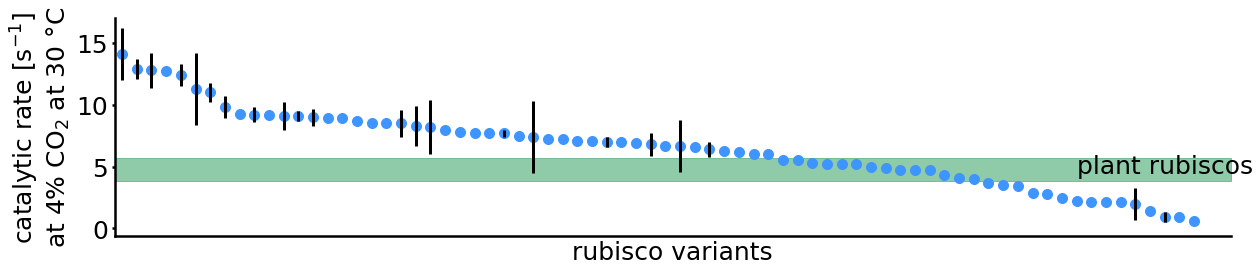

In [206]:
agg_d.loc[~agg_d['mean relative to Rr'].isna(),'index'] = pd.np.arange(len(agg_d[~agg_d['mean relative to Rr'].isna()]))
ax = agg_d.plot.scatter(x='index',y='mean relative to Rr',yerr='relative to Rr sem',color='k',rot=90,figsize=[20,4])
plt.fill_between(x=[-0.5,75.5],y1=plant_25per_30_deg,y2=plant_75per_30_deg,color='#229954',alpha=0.5)
agg_d.plot.scatter(x='index',y='mean relative to Rr',color='#3e95ff',rot=90,s=100,ax=ax)
#agg_d.plot.scatter(x='index',y='mean relative to Rr',color=agg_d['color'],rot=90,figsize=[20,4],ax=ax)
#plt.hlines(y=3.3*(2.2**0.5),xmin=-1,xmax=103,linestyles='--',color='#8c8c8c')
#plt.hlines(y=3.3*(2.2**0.5),xmin=-1,xmax=103,linestyles='--',color='#229954')
#plt.hlines(y=10,xmin=-1,xmax=103,linestyles='--',color='#8c8c8c')

plt.text(65,plant_25per_30_deg+0.6,'plant rubiscos')
#plt.text(80,10.5,'10 s$^{-1}$')
ax.set_ylabel('catalytic rate [s$^{-1}$]\nat 4% CO$_{2}$ at 30 $\degree$C')
ax.set_xlabel('rubisco variants')
#ax.set_xticks(pd.np.arange(len(agg_d[~agg_d['mean relative to Rr'].isna()])))
ax.set_xticks([])
ax.set_xlim([-0.5,75.5])
ax.set_xticklabels(agg_d.Variant)
#plt.savefig('fig3a.svg')

In [230]:
uclust[(uclust.ID == 'RBC4_10') & uclust.Query.str.contains('\[')].Query.apply(lambda x: x.split("[")[1])

#

#with_species.loc['RBC4_10']
#unique_species[unique_species.ID == 'RBC4_10']

,ID,Query
66,RBC4_10,GWA2_Gallionellales_54_124_curated


In [371]:
agg_d.to_csv('Variants with names.csv')

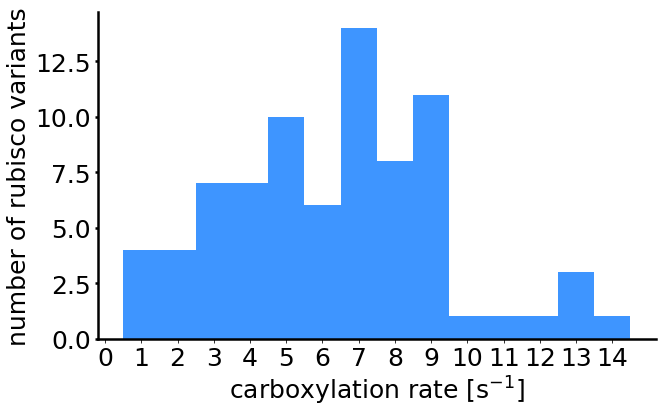

In [369]:
plt.rc('font', **font_large)

ax = agg_d['mean norm rate [s-1]'].plot.hist(bins=np.arange(0.5,15.5,1),xticks =np.arange(0,15,1),legend=False,color='#3e95ff',figsize=[10,6])
ax.set_xlabel('carboxylation rate [s$^{-1}$]')
ax.set_ylabel('number of rubisco variants')
plt.savefig('fig3b_20190613.svg')

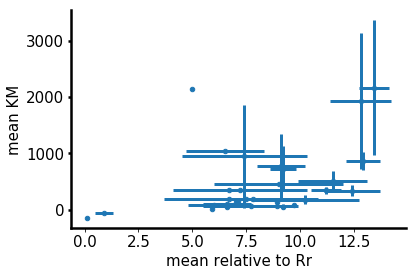

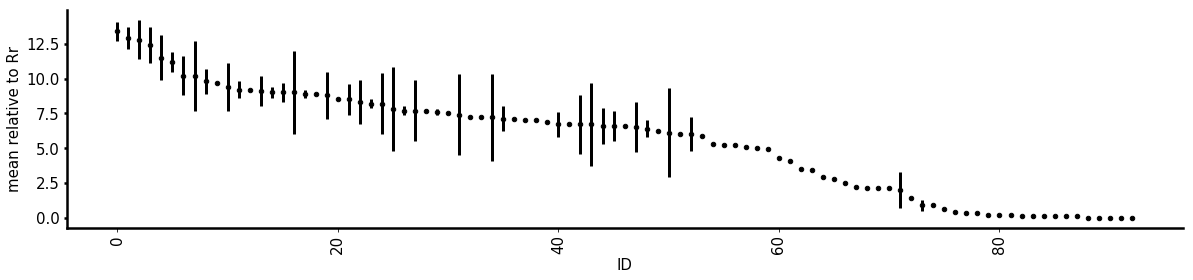

In [33]:
data = pd.read_csv('agg_variant_data_42_88_20190609.csv')
ax = data.plot.scatter(x='mean relative to Rr', y = 'mean KM',xerr = 'relative to Rr sem', yerr = 'KM sem')
data['ID'] = data.index
data.plot.scatter(x='ID',y='mean relative to Rr',yerr='relative to Rr sem',color='k',rot=90,figsize=[20,4])
